In [7]:
import pdfplumber
from pprint import pprint

In [2]:
doc = pdfplumber.open('data/E-STATEMENT_17May25_9601.pdf', password='MOHA1410')

In [3]:
p0 = doc.pages[0]

In [17]:
im = p0.to_image()
# im.save('data/page0.png')

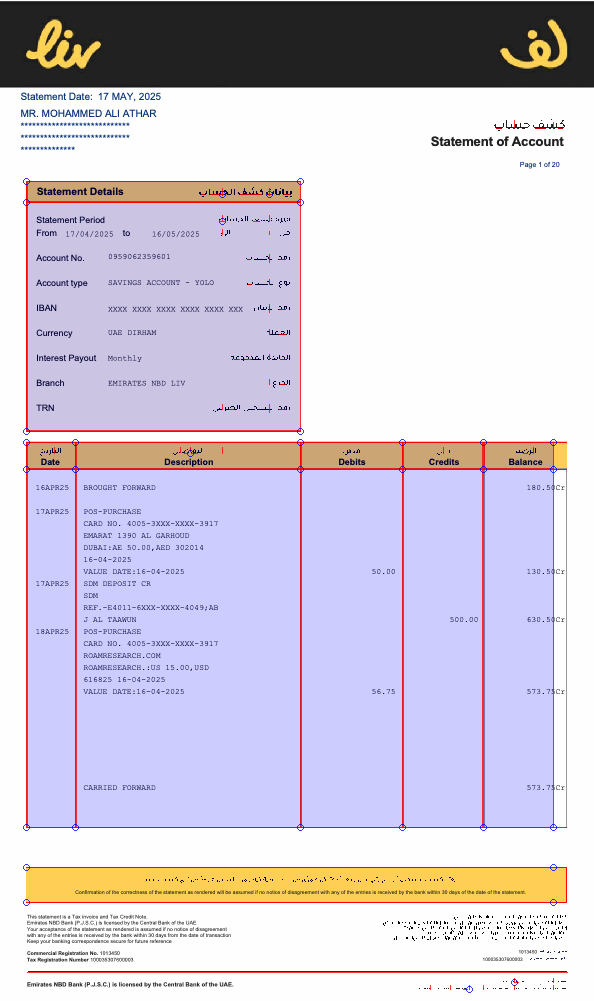

In [18]:
im.reset().debug_tablefinder()

In [5]:
table = p0.extract_table()

In [13]:
pprint(table[1])

['16APR25\n17APR25\n17APR25\n18APR25',
 'BROUGHT FORWARD\n'
 'POS-PURCHASE\n'
 'CARD NO. 4005-3XXX-XXXX-3917\n'
 'EMARAT 1390 AL GARHOUD\n'
 'DUBAI:AE 50.00,AED 302014\n'
 '16-04-2025\n'
 'VALUE DATE:16-04-2025\n'
 'SDM DEPOSIT CR\n'
 'SDM\n'
 'REF.-E4011-6XXX-XXXX-4049;AB\n'
 'J AL TAAWUN\n'
 'POS-PURCHASE\n'
 'CARD NO. 4005-3XXX-XXXX-3917\n'
 'ROAMRESEARCH.COM\n'
 'ROAMRESEARCH.:US 15.00,USD\n'
 '616825 16-04-2025\n'
 'VALUE DATE:16-04-2025\n'
 'CARRIED FORWARD',
 '50.00\n56.75',
 '500.00',
 '180.50\n130.50\n630.50\n573.75\n573.75']


In [73]:
table_settings = {
    'vertical_strategy': 'lines',
    'horizontal_strategy': 'text',
    'snap_y_tolerance': 7,
    'intersection_tolerance': 5,
}

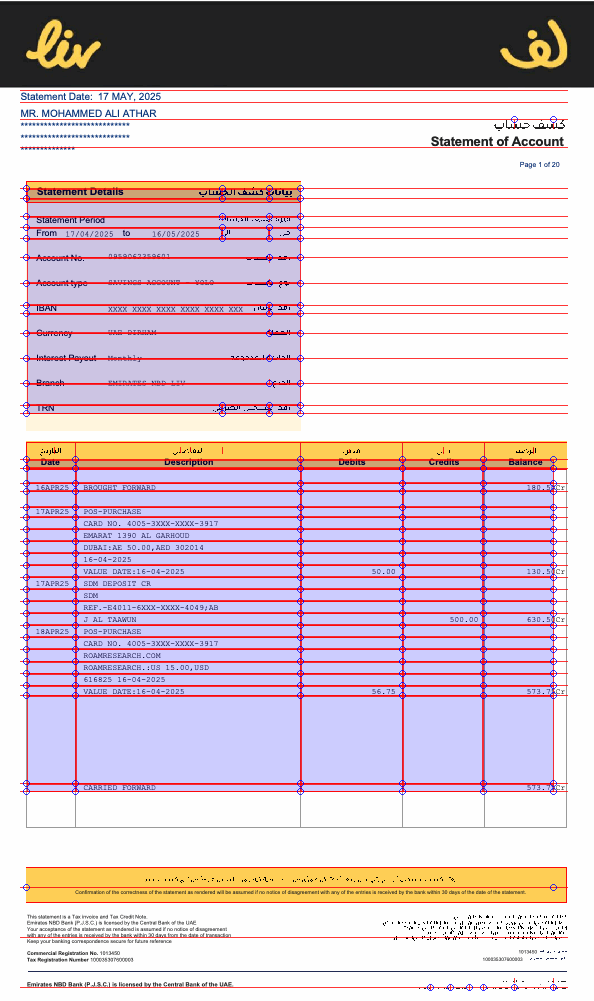

In [74]:
im.reset().debug_tablefinder(table_settings)

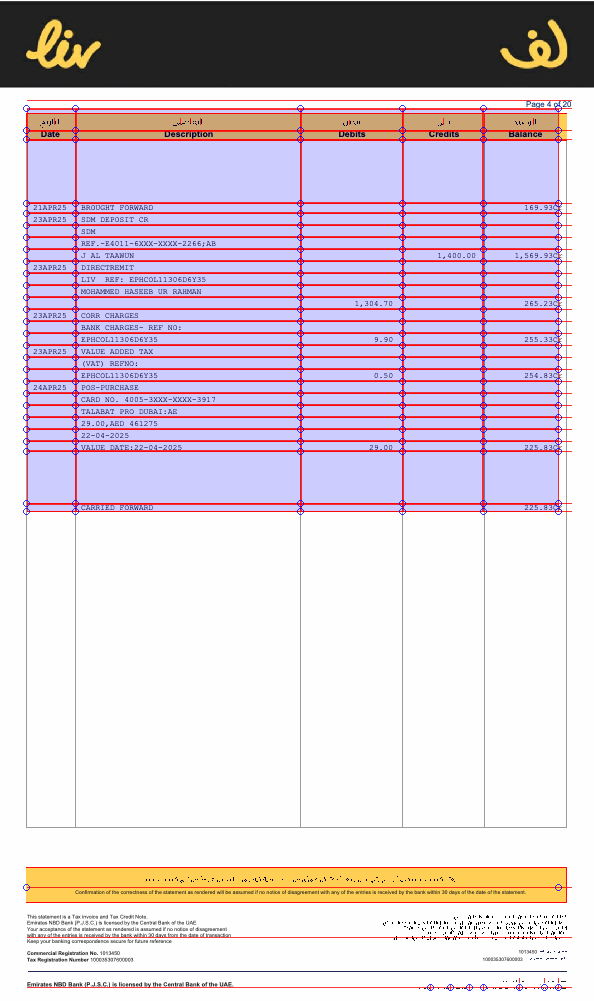

In [109]:
page_num = 3

page = doc.pages[page_num]

im = page.to_image()
im.debug_tablefinder(table_settings)
im

In [75]:
table_re = p0.extract_table(table_settings)

In [85]:
pprint(table_re[9])

['', 'VALUE DATE:16-04-2025', '50.00', '', '130.50']


In [97]:
processed_rows = []
ix = 1
max_ix = len(table_re[1:])

while ix < max_ix:
    row = table_re[ix]
    if any(row):
        date = None
        description = None
        debits = None
        credits = None
        balance = None


        row_found = False

        while not row_found and ix < max_ix:
            potential_date = row[0]
            potential_description = row[1]
            potential_debits = row[2]
            potential_credits = row[3]
            potential_balance = row[4]

            if potential_date and (potential_debits or potential_credits or potential_balance):
                #This is complete row
                print("reached complete row")
                print(row)
                processed_rows.append({
                    'date': potential_date,
                    'description': potential_description,
                    'debits': potential_debits,
                    'credits': potential_credits,
                    'balance': potential_balance
                })
                ix += 1
                row_found = True
            elif potential_date and potential_description:
                #This is the start of a new row
                date = potential_date
                description = potential_description
                ix += 1
                row = table_re[ix]
            elif potential_description and (potential_debits or potential_credits or potential_balance):
                #This is the end of a row
                description = description + ' ' + potential_description
                debits = potential_debits
                credits = potential_credits
                balance = potential_balance
                processed_rows.append({
                    'date': date,
                    'description': description,
                    'debits': debits,
                    'credits': credits,
                    'balance': balance
                })
                ix += 1
                row_found = True
            elif (potential_debits or potential_credits or potential_balance):
                #This is an alternate end of a row
                debits = potential_debits
                credits = potential_credits
                balance = potential_balance
                processed_rows.append({
                    'date': date,
                    'description': description,
                    'debits': debits,
                    'credits': credits,
                    'balance': balance
                })
                ix += 1
                row_found = True
            elif potential_description:
                #This is the continuation of a row
                description = description + ' ' + potential_description
                ix += 1
                row = table_re[ix]
            else:
                #This is the end of a row
                print("reached odd exception")
                print(row)
                ix += 1
                row_found = True
    else:
        ix += 1
        row = table_re[ix]


reached complete row
['16APR25', 'BROUGHT FORWARD', '', '', '180.50']


In [98]:
processed_rows


[{'date': '16APR25',
  'description': 'BROUGHT FORWARD',
  'debits': '',
  'credits': '',
  'balance': '180.50'},
 {'date': '17APR25',
  'description': 'POS-PURCHASE CARD NO. 4005-3XXX-XXXX-3917 EMARAT 1390 AL GARHOUD DUBAI:AE 50.00,AED 302014 16-04-2025 VALUE DATE:16-04-2025',
  'debits': '50.00',
  'credits': '',
  'balance': '130.50'},
 {'date': '17APR25',
  'description': 'SDM DEPOSIT CR SDM REF.-E4011-6XXX-XXXX-4049;AB J AL TAAWUN',
  'debits': '',
  'credits': '500.00',
  'balance': '630.50'},
 {'date': '18APR25',
  'description': 'POS-PURCHASE CARD NO. 4005-3XXX-XXXX-3917 ROAMRESEARCH.COM ROAMRESEARCH.:US 15.00,USD 616825 16-04-2025 VALUE DATE:16-04-2025',
  'debits': '56.75',
  'credits': '',
  'balance': '573.75'}]

In [100]:
import pandas as pd

In [101]:
df = pd.DataFrame(processed_rows)
df.columns = ['date', 'description', 'debits', 'credits', 'balance']

In [102]:
df.head()

,date,description,debits,credits,balance
0,16APR25,BROUGHT FORWARD,,,180.50
1,17APR25,POS-PURCHASE CARD NO. 4005-3XXX-XXXX-3917 EMAR...,50.00,,130.50
2,17APR25,SDM DEPOSIT CR SDM REF.-E4011-6XXX-XXXX-4049;A...,,500.00,630.50
3,18APR25,POS-PURCHASE CARD NO. 4005-3XXX-XXXX-3917 ROAM...,56.75,,573.75
